In [2]:
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from ff_energy.ffe.utils import read_from_pickle
import jax.numpy as jnp
from ff_energy.ffe.plot import plot_energy_MSE, plot_ff_fit
from ff_energy.ffe.structure import atom_key_pairs
from ff_energy.ffe.potential import LJ, akp_indx
from ff_energy.ffe.ff import FF
from ff_energy.ffe.ff_fit import LJ_bound, load_ff, fit_func, fit_repeat
from ff_energy.ffe.data import pairs_data
from ff_energy.ffe.utils import pickle_output, read_from_pickle, str2int




In [3]:
sig_bound = (0.001, 2.5)
ep_bound = (0.001, 2.5)
chg_bound = (100,2000)

CHGPEN_bound = [(chg_bound),(chg_bound),(chg_bound),(chg_bound),(0,2000)]
LJ_bound = ((sig_bound), (sig_bound), (ep_bound), (ep_bound))
DE_bound = ((sig_bound), (sig_bound), (ep_bound), (ep_bound), 
            (1, 8), (6, 20))

In [4]:
#  example
# ffpkl = "ECOL_pbe0dz_FOE.ff.pkl"
ffpkl = "pc_pbe0dz_clusters.ff.pkl"

In [5]:
_c = next(read_from_pickle(f"ff/{ffpkl}"))
_c

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


FF: LJ water_cluster ELEC harmonic intE (jax_coloumb: True)

In [6]:
_c.intE = "ECOL"
_c.set_targets()
# _c.targets
# _c.data.ECOL
# _c.data.ELEC

In [7]:
fit_repeat(_c, 
           1, 
           f"{ffpkl}_chgpen",
           bounds = CHGPEN_bound,
           loss="chgpen",
           quiet='true'
          )

/home/boittier/Documents/phd/ff_energy/ff_energy/ffe/ff_fit.py:175: OptimizeWarning: Unknown solver options: pgtol
  res = minimize(


In [8]:
resx = _c.opt_parm 

loss = _c.get_loss_chgpen(resx)
loss
resx

array([1298.50465612,  565.62098925, 1909.28053496, 1475.69870437,
        313.06505974])

In [9]:
np.sqrt(loss)

14.346986

In [10]:
# _c.eval_jax_chgpen(resx ) 

1.1750395324150466e-144


(<Axes: xlabel='NBOND energy\n(kcal/mol)', ylabel='CCSD(T) interaction energy\n(kcal/mol)'>,
 {'MSE': 205.83599198839843,
  'RMSE': 14.34698546693341,
  'R': 0.8557956325503473,
  'RS': 0.8396742706970828,
  'n': 500,
  'slope': 0.937521712853103,
  'intercept': -6.03905194752862})

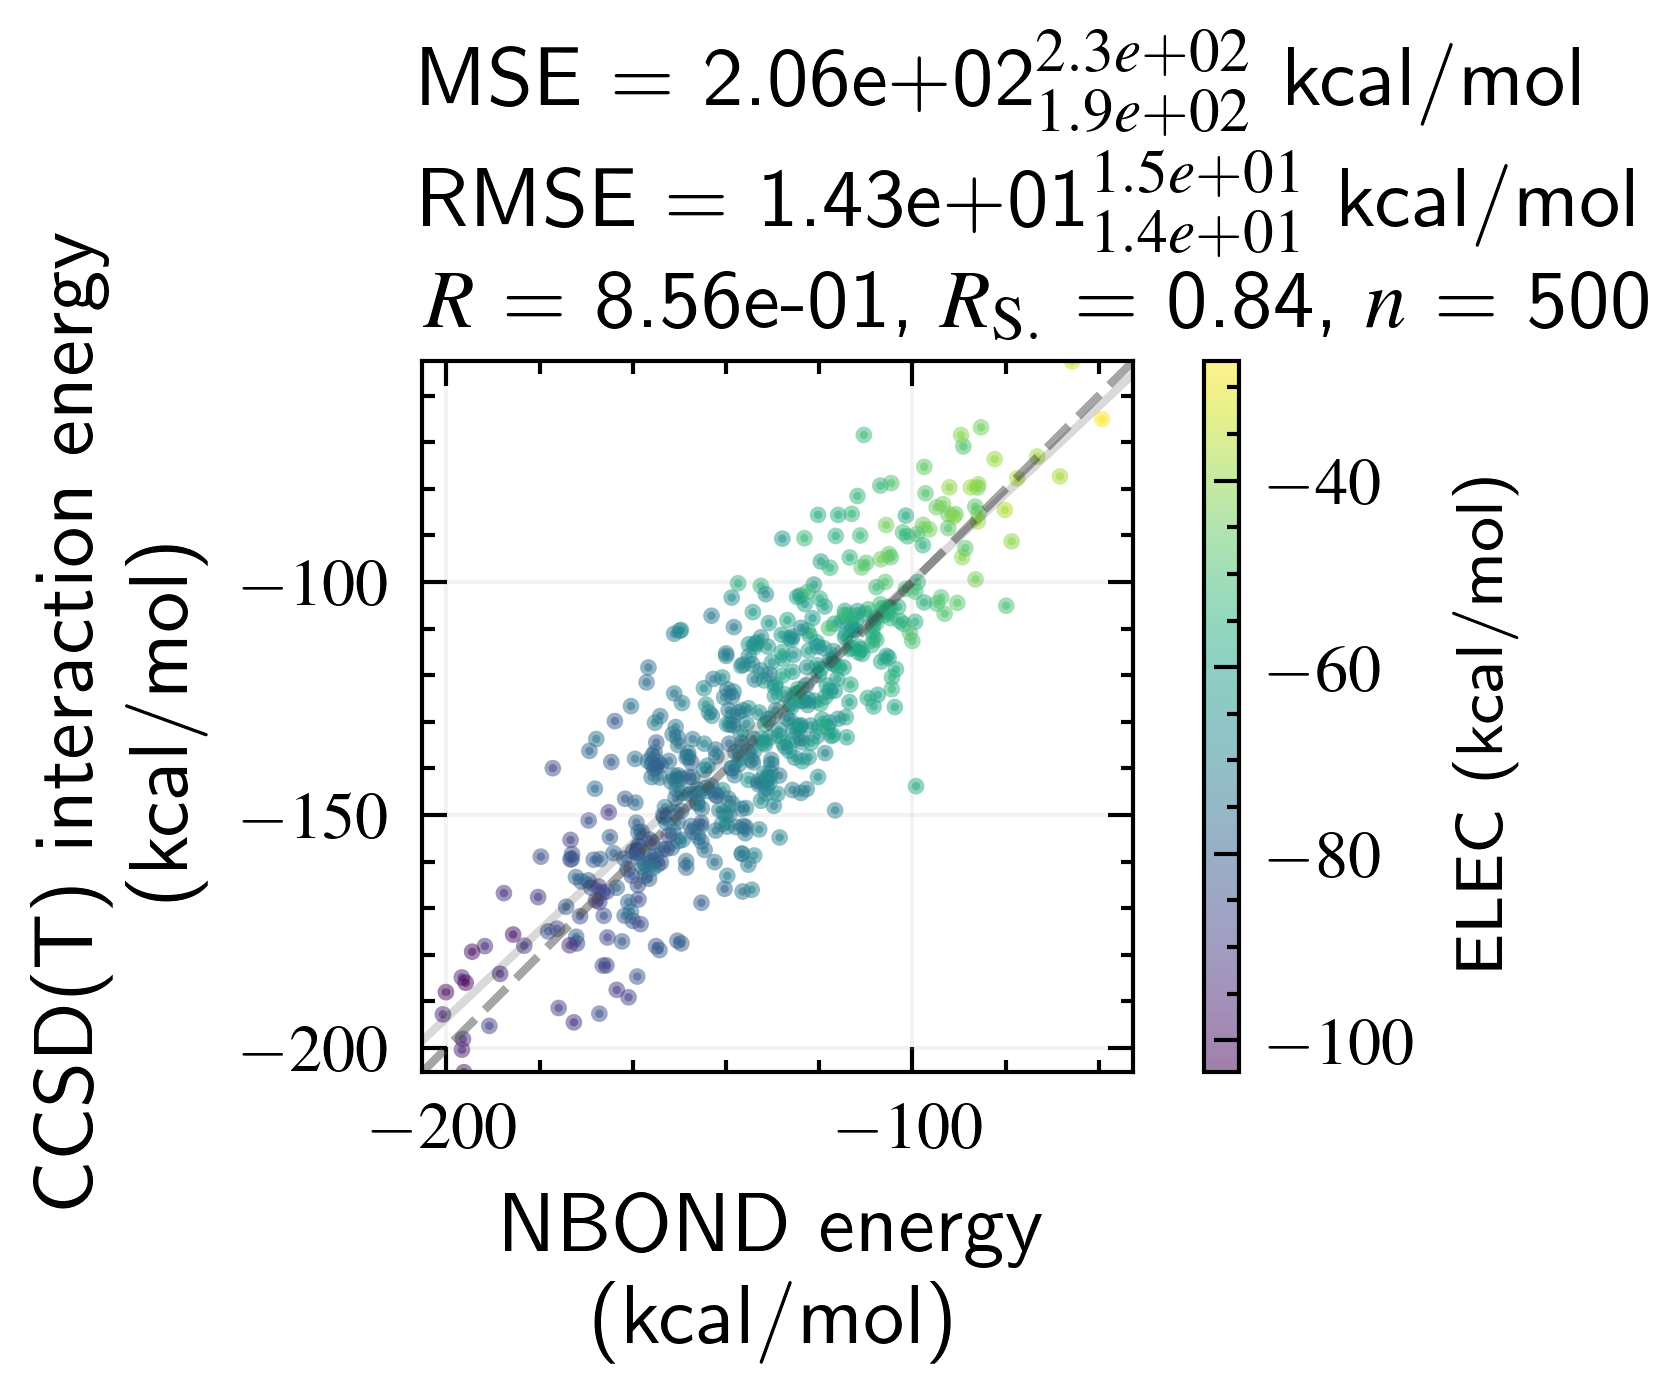

In [11]:
# _c.eval_jax_chgpen(resx ) 
_c.data["fit_ECOL"] = _c.eval_jax_chgpen(resx ) + _c.data.ELEC
plot_energy_MSE(_c.data, "ECOL", "fit_ECOL",  elec = "ELEC")

2.5608014994665487e-245


(<Axes: xlabel='NBOND energy\n(kcal/mol)', ylabel='CCSD(T) interaction energy\n(kcal/mol)'>,
 {'MSE': 4527.964453647834,
  'RMSE': 67.29015123811087,
  'R': 0.9457588017676065,
  'RS': 0.9416012384049537,
  'n': 500,
  'slope': 0.4930125400388275,
  'intercept': -1.8806212356120398})

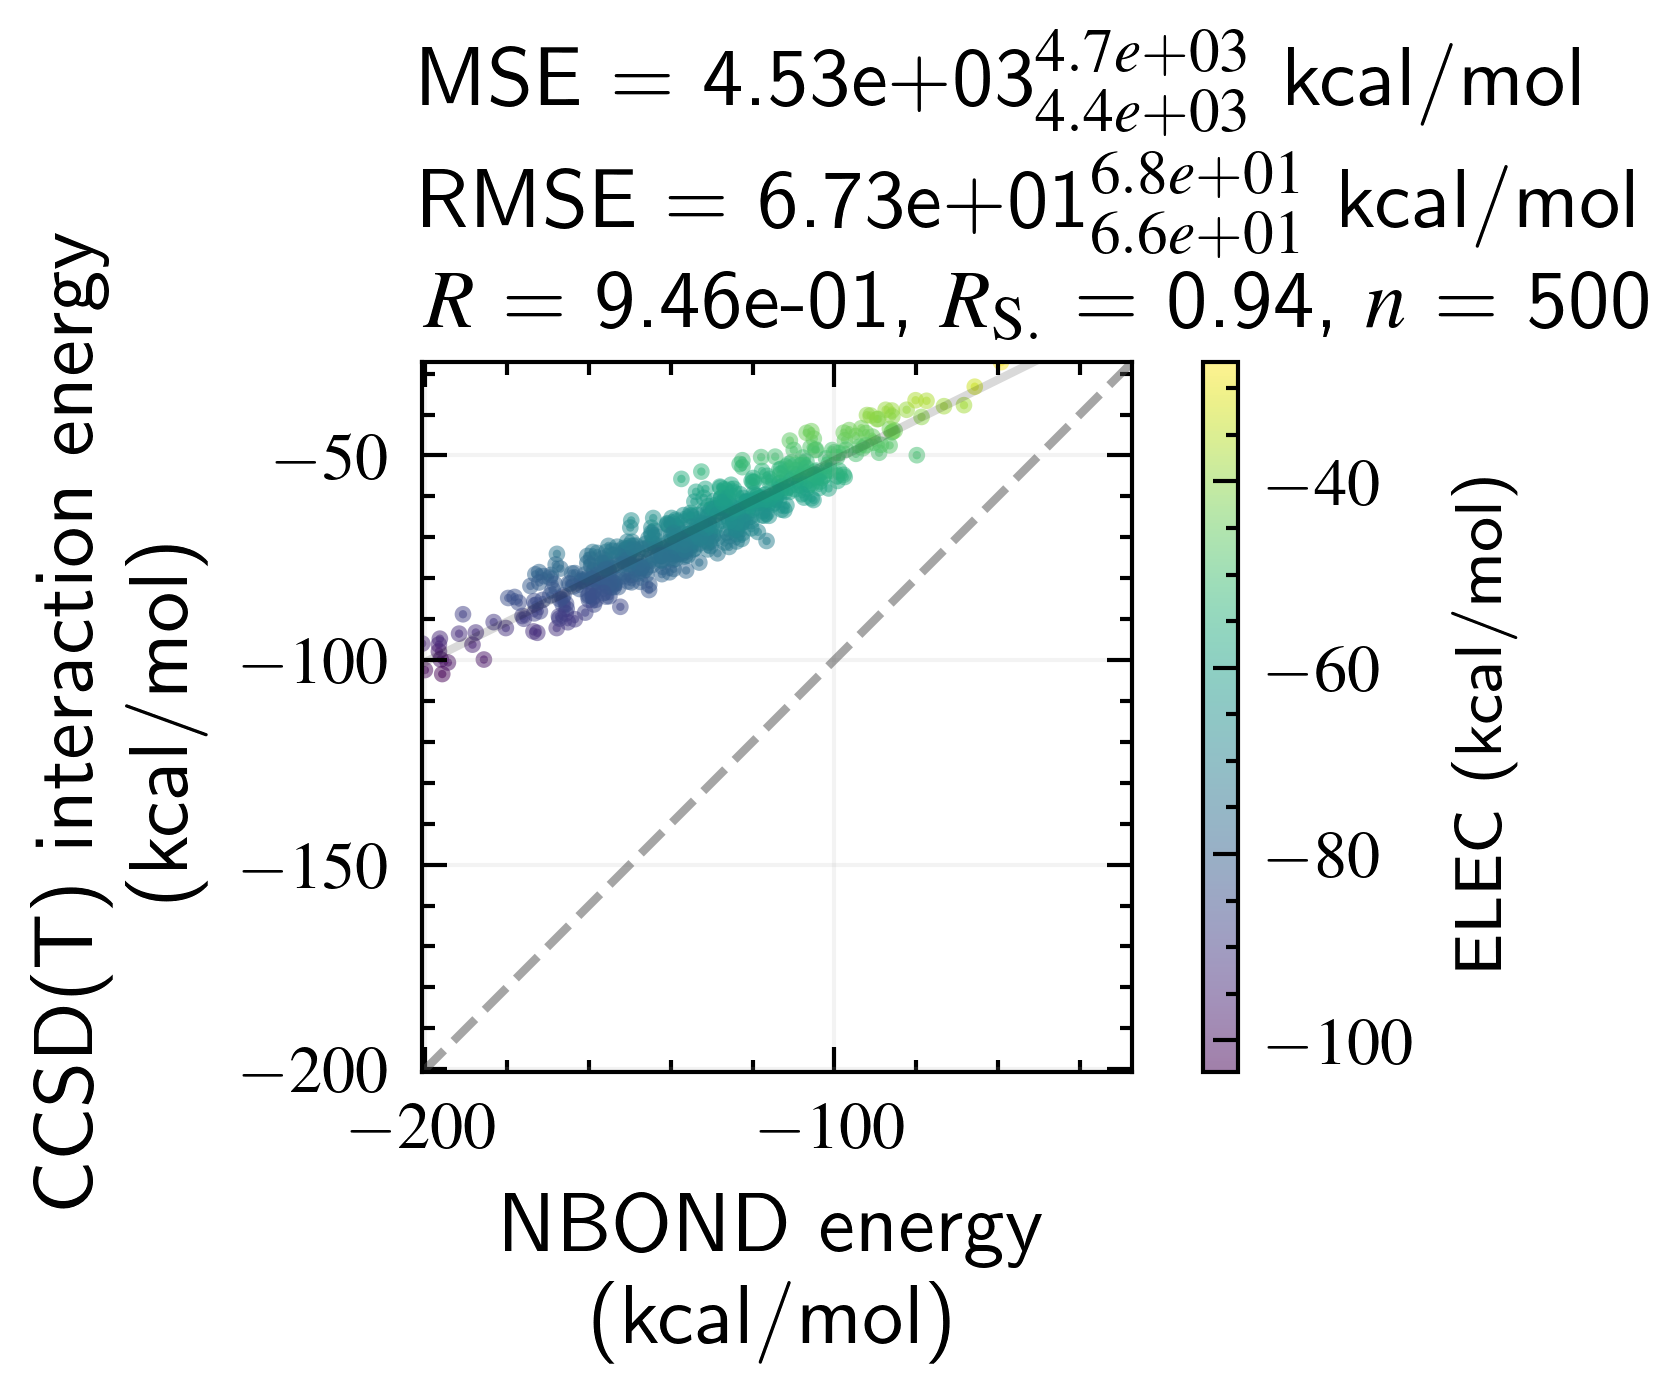

In [12]:
plot_energy_MSE(_c.data, "ECOL", "ELEC",  elec = "ELEC")

In [13]:
pickle_output(_c, "ff/fit_ECOL_pc_intE")

#  LJ fit


In [30]:
# _c = next(read_from_pickle(f"ff/{ffpkl}"))
LJFF = next(read_from_pickle(f"ff/fit_ECOL_pc_intE.pkl"))
LJFF.elec = "fit_ECOL"
LJFF.intE = "intE"
LJFF.set_intE()
LJFF.set_targets()
print(LJFF.targets.mean())
LJFF

72.37689


FF: LJ water_cluster fit_ECOL harmonic intE (jax_coloumb: True)

In [31]:
# _c.targets

In [37]:
fit_repeat(LJFF, 
           30, 
           f"{ffpkl}_LJ",
           bounds = LJ_bound,
           loss="jax",
           quiet='true'
          )

/home/boittier/Documents/phd/ff_energy/ff_energy/ffe/ff_fit.py:175: OptimizeWarning: Unknown solver options: pgtol
  res = minimize(


In [35]:
pd.DataFrame(LJFF.opt_results).sort_values("fun")

,fun,nit,nfev,status,success,message,x,final_simplex
5,178.253128,543,923,0,True,Optimization terminated successfully.,"[0.13611750002134923, 2.5, 0.001, 0.0039198876...","([[0.13611750002134923, 2.5, 0.001, 0.00391988..."
0,205.836014,113,293,0,True,Optimization terminated successfully.,"[1298.5046561174304, 565.6209892539468, 1909.2...","([[1298.5046561174304, 565.6209892539468, 1909..."
2,433.241791,329,588,0,True,Optimization terminated successfully.,"[1.7849920027609416, 0.965407327336054, 0.0010...","([[1.7849920027609416, 0.965407327336054, 0.00..."
1,5606.608398,42,142,0,True,Optimization terminated successfully.,"[0.02868711896807108, 0.05030470503616231, 2.4...","([[0.02868711896807108, 0.05030470503616231, 2..."
3,5606.608398,41,143,0,True,Optimization terminated successfully.,"[0.030521599329832894, 0.001, 2.5, 1.197800309...","([[0.030521599329832894, 0.001, 2.5, 1.1978003..."
4,5606.608398,55,165,0,True,Optimization terminated successfully.,"[0.001, 0.045348097351979866, 2.49102864703257...","([[0.001, 0.045348097351979866, 2.491028647032..."
6,5606.608398,40,143,0,True,Optimization terminated successfully.,"[0.001, 0.001, 2.108881708245354, 2.5]","([[0.001, 0.001, 2.108881708245354, 2.5], [0.0..."


In [36]:
best = list(pd.DataFrame(\
                  LJFF.opt_results)\
     .sort_values("fun").fun)[0]
np.sqrt(best)

13.35114706876371

#  DE fit


In [21]:
# _c = next(read_from_pickle(f"ff/{ffpkl[:-4]}_chgpen.pkl"))
DEFF = next(read_from_pickle(f"ff/fit_ECOL_pc_intE.pkl"))
DEFF.elec = "fit_ECOL"
DEFF

FF: LJ water_cluster fit_ECOL harmonic ECOL (jax_coloumb: True)

In [25]:
fit_repeat(DEFF, 
           1, 
           "test",
           bounds = DE_bound,
           loss="jax_de",
           quiet='true'
          )

/home/boittier/Documents/phd/ff_energy/ff_energy/ffe/ff_fit.py:175: OptimizeWarning: Unknown solver options: pgtol
  res = minimize(


In [26]:
pd.DataFrame(DEFF.opt_results).sort_values("fun")

,fun,nit,nfev,status,success,message,x,final_simplex
11,31.263338,1488,2346,0,True,Optimization terminated successfully.,"[0.3739262372769826, 1.2886064967824316, 2.499...","([[0.3739262372769826, 1.2886064967824316, 2.4..."
2,31.263659,853,1376,0,True,Optimization terminated successfully.,"[0.3740962927823759, 1.2891946191421564, 2.5, ...","([[0.3740962927823759, 1.2891946191421564, 2.5..."
3,31.265627,1496,2350,0,True,Optimization terminated successfully.,"[0.3742258582268552, 1.2883724010341104, 2.499...","([[0.3742258582268552, 1.2883724010341104, 2.4..."
4,31.417833,747,1214,0,True,Optimization terminated successfully.,"[0.37491177305284973, 1.2926563552141728, 2.5,...","([[0.37491177305284973, 1.2926563552141728, 2...."
1,31.476809,1093,1772,0,True,Optimization terminated successfully.,"[0.37395404500730267, 1.2884842346147107, 2.48...","([[0.37395404500730267, 1.2884842346147107, 2...."
9,32.093956,1038,1708,0,True,Optimization terminated successfully.,"[0.3776267108937452, 1.2843723466945236, 2.5, ...","([[0.3776267108937452, 1.2843723466945236, 2.5..."
7,35.427544,1027,1647,0,True,Optimization terminated successfully.,"[0.4298951655896703, 1.2362652449246934, 2.196...","([[0.4298951655896703, 1.2362652449246934, 2.1..."
8,57.939037,735,1260,0,True,Optimization terminated successfully.,"[0.9034867608030792, 0.6271129876645916, 1.196...","([[0.9034867608030792, 0.6271129876645916, 1.1..."
10,61.712650,353,631,0,True,Optimization terminated successfully.,"[0.3775051731464083, 0.45762966296838137, 2.49...","([[0.3775051731464083, 0.45762966296838137, 2...."
5,64.938522,451,807,0,True,Optimization terminated successfully.,"[0.9389219960651293, 0.7489165017720218, 1.926...","([[0.9389219960651293, 0.7489165017720218, 1.9..."


In [24]:
# np.sqrt(31.166512)

5.58269755584162

In [27]:
list(pd.DataFrame(\
                  DEFF.opt_results)\
     .sort_values("fun").x)[0]

array([ 0.37392624,  1.2886065 ,  2.49998207,  2.49991982,  6.27534424,
       15.58825269])

In [28]:
list(pd.DataFrame(\
                  DEFF.opt_results)\
     .sort_values("fun").)[0]

array([ 0.37392624,  1.2886065 ,  2.49998207,  2.49991982,  6.27534424,
       15.58825269])